LangGraph Components

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

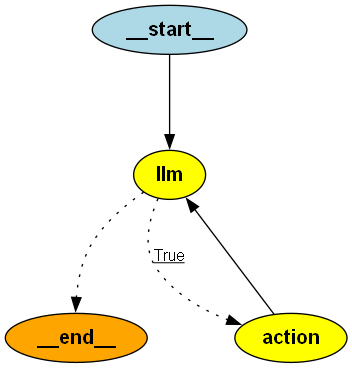

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_gvOs5qHoUxVptzGOJ0LDaxKX'}
Back to the model!


In [9]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gvOs5qHoUxVptzGOJ0LDaxKX', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0f691fdb-cb5c-4573-b6d0-217695c6ce1c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_gvOs5qHoUxVptzGOJ0LDaxKX'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122

In [10]:
result['messages'][-1].content

'The current weather in San Francisco is sunny with a temperature of 64.0°F (17.8°C). The wind speed is 5.6 mph (9.0 kph) coming from the WSW direction. The humidity is at 73%, and there is no precipitation at the moment.'

In [11]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_Htodkd4R0uEUeGlnmBglFNCj'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_Jmr30l8AzZ5nIrxa9EdUmzvM'}
Back to the model!


In [12]:
result['messages'][-1].content

'The current weather in San Francisco is 64°F with sunny conditions. In Los Angeles, the current weather is 72°F with partly cloudy skies.'

In [13]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_f5TW7ZvsNJ6LZNXNBTtH3mMv'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of the state where the 2024 Super Bowl winning team is headquartered'}, 'id': 'call_7Y83hLYtu3F4zquudOljlZ7z'}
Back to the model!


In [14]:
print(result['messages'][-1].content)

### Super Bowl 2024 Winner
The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers in an overtime victory.

### State of Winning Team's Headquarters
The Kansas City Chiefs are headquartered in Kansas City, Missouri.

### GDP of Missouri
Missouri's Gross Domestic Product (GDP) is not directly available in the search results, but typically, the Bureau of Economic Analysis (BEA) or other economic resources would provide the latest GDP figures. As of the latest data available, Missouri's GDP is approximately $374 billion. For the most current figure, one should refer to the latest reports from the BEA or similar authoritative sources.
